In [1]:
import time
import os
from os import listdir
from os.path import join, isfile

import numpy as np
import numpy.matlib
import pandas as pd
import pyedflib
from scipy.signal import find_peaks_cwt, welch
from scipy.signal import decimate
from datetime import timedelta
from mne.filter import filter_data

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')

/Users/jeroenhabets/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Technical validation of wearable sensor data and ecological momentary assessment (EMA) data in real-life Parkinson monitoring.

This notebook provides the code to perform a proof-of-principle, technical validation, belonging to the database shared on DataVerseNL (https://dataverse.nl/dataset.xhtml?persistentId=doi:10.34894/5HHK8H).

To use the data and this notebook the following folder structure should be used:
- Create one main folder, and call this path in the next cell.
- The main folder should contain a folder 'data', and a folder 'results'.
- The folder 'data' should contain one folder per patient. Each folder should be named with the patient code, e.g. '110018', and should contain all sensor data edf-files as provided on DataverseNL.
- The data-folder will be used to save working files containing extracted sensor and EMA-data, and features.
- The results-folder will be used to save the png-images which are the results of this notebook.

In [2]:
path = '/Users/jeroenhabets/Desktop/python_code/Sensor_EMA_PD_monitoring'


### I. Data Preparation - Loading and Selection
Loads in sensor and EMA data from raw files.

Selects and extracts both EMA and sensor data based on completed beep questionnaires in EMA data. Saves per patient the EMA data and the corresponding sensor data in separate files 'pt_trials.npy' and 'pt_esm.csv'. These files are required to create Features in section II.

In [102]:


def get_file_lists(subject):
    '''
    Creates a list of files for each sensor (Left/right/chest) located in the indicated patients
    sensor file folder.
    
    '''
    subj_folder = os.path.join(path,'data',subject)

    # sensor names
    left_sensors = ['13797', '13799', '13794', '13806']
    right_sensors = ['13805', '13801', '13793', '13795']
    chest_sensors = ['13804', '13792', '13803', '13796']

    edf_files = [f for f in listdir(subj_folder) if (isfile(join(subj_folder, f))) and (f[0] != '_' and f[-3:] == 'edf')]

    left_files = []
    right_files = []
    chest_files = []

    for f in edf_files:
        if f[0:5] in left_sensors:
            left_files.append(join(subj_folder, f))
        elif f[0:5] in right_sensors:
            right_files.append(join(subj_folder, f))
        elif f[0:5] in chest_sensors:
            chest_files.append(join(subj_folder, f))

    left_files = sorted(left_files)
    right_files = sorted(right_files)
    chest_files = sorted(chest_files)

    return left_files, right_files, chest_files


def extract_raw_trials(left_files, right_files, chest_files, esm_frame,
                       esm_window_length=15, feature_window_length=60):
    '''
    Reads the sensor files and aligns the data with the esm data. Then
    data quality is checked.
    Returns cleaned and synced trial data and ESM beeps
    '''

    files = [left_files, right_files, chest_files]

    n_beeps = esm_frame.shape[0]
    n_sensors = len(files)
    trials = [[[]] * n_beeps] * n_sensors
    trials = np.zeros((n_sensors,n_beeps,int(esm_window_length * WINDOW_LENGTH * 100),6))

    found_trials = np.zeros((n_beeps, n_sensors))
    for i, f in enumerate(files):
        for file in f:
            print(file)

            # Read the data from the filepath, raise error if file is not in the correct format
            try:
                labels, timestamps, data, fs = read_edf_data(file)  # as input instead: leftFiles
                if data.shape[1] < fs * feature_window_length:
                    raise ValueError('File too short to proceed.')
            except Exception:
                print('%s is broken' % file)
                continue

            data = pd.DataFrame(data.T, index=timestamps)
            for beep in range(n_beeps):
                if found_trials[beep, i] == 1:
                    continue

                # Get the corresponding time
                beep_time = pd.to_datetime(esm_frame['beep_time_start'].iloc[beep])
                timediff = np.min(np.abs(data.index - beep_time))
                # Find corresponding moment for beep time in the sensor data by
                # calculating the difference in sensor and beep timestamps and
                # select the index with the smallest difference.
                if timediff > timedelta(minutes=esm_window_length):
                    # If the time difference is larger than the window length,
                    # remove beep
                    continue
                pos = np.argmin(np.abs(data.index - beep_time))
                # For the smallest time difference, find the position in the sensor data
                if pos > esm_window_length * WINDOW_LENGTH * fs:
                    trials[i,beep,:,:] = data.iloc[pos - (int(esm_window_length * WINDOW_LENGTH * fs)):pos].values
                    found_trials[beep, i] = 1
    
    keep = np.sum(found_trials, axis=1) == n_sensors  # Keep trials if all three sensors contain values
    trialData = np.zeros((np.sum(keep), int(esm_window_length * WINDOW_LENGTH * fs), 3 * 6))
    counter = 0
    for beep in range(n_beeps):
        if keep[beep]:
            temp = np.concatenate((trials[0,beep,:,:], trials[1,beep,:,:], trials[2,beep,:,:]), axis=1)
            trialData[counter, :, :] = temp
            counter += 1
    foundESM = esm_frame.iloc[keep, :]

    return trialData, foundESM


def read_edf_data(filename):
    '''
    Reads and .edf file and returns labels, timestamps, signal buffers and samplefrequency.
    '''

    # Extract data
    f = pyedflib.EdfReader(filename)
    fs = f.getSampleFrequencies()[0]
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sig_bufs = np.zeros((n, f.getNSamples()[0]))

    for i in np.arange(n):
        sig_bufs[i, :] = f.readSignal(i)

    # Get starting time
    starting_time = filename[-19:-4]
    starting_time = pd.to_datetime(starting_time, format='%Y%m%d_%H%M%S', errors='ignore')

    sig_bufs = decimate(sig_bufs, DOWNSAMPLING, axis=1)
    fs = fs / DOWNSAMPLING
    freq = '%d ms' % (1000 / fs)
    timestamps = pd.date_range(start=starting_time, periods=sig_bufs.shape[1], freq=freq)

    return signal_labels, timestamps, sig_bufs, fs



In [103]:
if __name__ == '__main__':
    # constants
    WINDOW_LENGTH = 60
    DOWNSAMPLING = 2
    FEATURE_WINDOW_LENGTH = 60
    ESM_WINDOW_LENGTH = 15

    # define patient to use
    all_subjs = ['110018']

    esm = pd.read_csv(os.path.join(path,'data','EMA_data.csv'), )

    for subject in all_subjs:
        leftFiles, rightFiles, chestFiles = get_file_lists(subject)
        t = time.time()
        trial_data, selected_esm = extract_raw_trials(leftFiles, rightFiles, chestFiles, esm[esm['ID'] == int(subject)])
        print(time.time() - t)
        print(trial_data.shape)
        print(selected_esm.shape)
        np.save(os.path.join(path,'data', subject + '_trials.npy'), trial_data.astype(np.float32))
        selected_esm.to_csv(os.path.join(path,'data', subject + '_esm.csv'), index=False)
        

/Users/jeroenhabets/Desktop/python_code/Sensor_EMA_PD_monitoring/data/110018/13797_20190109_083149.edf
/Users/jeroenhabets/Desktop/python_code/Sensor_EMA_PD_monitoring/data/110018/13797_20190110_092745.edf
/Users/jeroenhabets/Desktop/python_code/Sensor_EMA_PD_monitoring/data/110018/13797_20190111_000000.edf
/Users/jeroenhabets/Desktop/python_code/Sensor_EMA_PD_monitoring/data/110018/13797_20190111_061000.edf
/Users/jeroenhabets/Desktop/python_code/Sensor_EMA_PD_monitoring/data/110018/13797_20190112_084509.edf
/Users/jeroenhabets/Desktop/python_code/Sensor_EMA_PD_monitoring/data/110018/13797_20190113_000000.edf
/Users/jeroenhabets/Desktop/python_code/Sensor_EMA_PD_monitoring/data/110018/13797_20190113_100711.edf
/Users/jeroenhabets/Desktop/python_code/Sensor_EMA_PD_monitoring/data/110018/13797_20190114_072923.edf
/Users/jeroenhabets/Desktop/python_code/Sensor_EMA_PD_monitoring/data/110018/13797_20190114_212039.edf
/Users/jeroenhabets/Desktop/python_code/Sensor_EMA_PD_monitoring/data/110

## II. Data Preparation - Feature Extraction

The next section requires the files 'pt_trials.npy' and 'pt_esm.csv' in the data-folder as a result of the previous section.
It will produce a csv-file containing features for medication state classification. The csv-file will be stored in the data-folder.



In [104]:


def extractFeatures(data, esm,sr, windowLength=60):

    numSamples=data.shape[0]
    # Getting number and names of features
    tremorNames, _ = tremorFeatures(data[0,:windowLength*sr,:], sr,windowLength=windowLength)
    bradyNames, _ = bradykinesiaFeatures(data[0,:windowLength*sr,:], sr,windowLength=windowLength)
    cols=[]
    for s in ['L','R','C']:
        cols.extend([c + s for c in tremorNames])
        cols.extend([c + s for c in bradyNames])
    cols.extend(esm.keys())
    aligned = pd.DataFrame(columns=cols)
    accelerometerChannel = [a + b for a in  [0,6,12] for b in range(3)]
    for beep in np.arange(data.shape[0]):
        t=time.time()
        allFeat = []
        numWindows = int(data.shape[1]/sr/windowLength)
        buff = data[beep,:,:]
        buff[:,accelerometerChannel] = (buff[:,accelerometerChannel].T - np.mean(buff[:,accelerometerChannel].T,axis=0)).T
        for s,sID in enumerate([range(6),range(6,12),range(12,18)]):
            
            features=np.zeros((numWindows,len(tremorNames)+len(bradyNames)))
            for i in range(0,numWindows):
                win = i * windowLength * sr
                _, features[i,:len(tremorNames)] = tremorFeatures(buff[win:win+windowLength*sr,sID],sr,windowLength=windowLength)
                _, features[i,len(tremorNames):] = bradykinesiaFeatures(buff[win:win+windowLength*sr,sID],sr,windowLength=windowLength)
            allFeat.append(features)
        allFeat = np.concatenate(allFeat,axis=1)
        allFeat = np.concatenate((allFeat, np.matlib.repmat(esm.iloc[beep,:],numWindows,1)),axis=1)
        aligned = aligned.append(pd.DataFrame(allFeat,columns = cols),ignore_index=True)
    
    return aligned 



def tremorFeatures(windowData,sr,windowLength=60):
    tremorChannel={'AccX':0,'AccY':1,'AccZ':2,'GyrX':3,'GyrY':4,'GyrZ':5} 
    if windowData.shape[0]!=sr*windowLength:
        print(windowData.shape,sr*windowLength)
    features=[]
    featureNames=[]
    for ch in tremorChannel.keys():
        f, spec = welch(windowData[:,tremorChannel[ch]], fs=sr, nperseg=sr )
        selected = np.logical_and(f>3.5,f<7.5)
        spec = np.mean(np.log(spec[selected]))
        features.append(spec)
        featureNames.append('TremorPower' + ch)
        
        
    return featureNames, features



def bradykinesiaFeatures(windowData,sr,windowLength=60):
    features=[]
    featureNames=[]
    accelerometerChannel={'accX':0,'accY':1,'accZ':2} 
    windowData = filter_data(windowData[:,list(accelerometerChannel.values())].T,sr,0,3,method='iir',verbose='WARNING').T
    
    freq = np.fft.rfftfreq(windowLength*sr, d=1./sr)
    
    for ch in accelerometerChannel.keys():
        f, spec = welch(windowData[:,accelerometerChannel[ch]], fs=sr, nperseg=sr )
        selected = np.logical_and(f>0.5,f<3.0)
        spec = np.mean(np.log(spec[selected])) 
        features.append(spec)
        featureNames.append('bradyPower' + ch)
        
        spec = np.abs(np.fft.rfft(windowData[:,accelerometerChannel[ch]]))
        domFreq = freq[np.argmax(spec)]
        features.append(domFreq)
        featureNames.append('DomFreq' + ch)
        
        domEnergyRatio = np.max(spec) / np.sum(spec)
        features.append(domEnergyRatio)
        featureNames.append('DomEnergyRatio' + ch)
        
        rms = np.sqrt(np.mean(windowData[:,accelerometerChannel[ch]]**2))
        features.append(rms)
        featureNames.append('RMS' + ch)
        
        ampRange = np.max(windowData[:,accelerometerChannel[ch]]) - np.min(windowData[:,accelerometerChannel[ch]])
        features.append(ampRange)
        featureNames.append('AmpRange' + ch)
    
    cCMax=[]
    cCLocs=[]
    for i, ch1 in enumerate(accelerometerChannel.keys()):
        for j,ch2 in enumerate(list(accelerometerChannel.keys())[i+1:]):
            crossCorr = np.correlate(windowData[:,accelerometerChannel[ch1]],windowData[:,accelerometerChannel[ch2]],'same')
            crossCorr = crossCorr/(np.std(windowData[:,accelerometerChannel[ch1]]) * np.std(windowData[:,accelerometerChannel[ch2]]))
            
            cCMax.append(np.max(crossCorr))
            cCLocs.append(np.argmax(crossCorr))
    features.append(np.max(cCMax))
    featureNames.append('MaxCC')
    features.append(cCLocs[np.argmax(cCMax)])
    featureNames.append('MaxCCLoc')
        
    return featureNames, features




        
        

110018


In [ ]:
if __name__ == '__main__':
    allPts = ['110018'] 
    sr=100
    winL = 900 # seconds
    for pt in allPts:
        print(pt)
        trialData = np.load(join(path,'data', pt + '_trials.npy')).astype(np.float64)
        esm = pd.read_csv(join(path,'data',  pt + '_esm.csv'))
        alignedFeatures = extractFeatures(trialData,esm,sr,windowLength=winL)
        alignedFeatures.to_csv(join(path,'data',  pt + '_features' +  str(winL)  + '.csv'),index=False)



## III. Classification Analysis

Function to perform classification analysis on Medication States.

Needs pre-processed features-fil containing sensor and EMA data from previous section.

Requires patient-code as input, and definition of the source of sensor data to use, 'chest' or 'wrists' can be chosen to perform the analysis with respectively chest-sensor data or left- and right-wrist sensor data.
The function will store the resulting png-file in the results-folder.

In [62]:
def predictMedState(pt, sensor_source):
    '''
    Input:
    pt = pt-code as string, e.g. '110018'
    sensor_source = 'wrists' or 'chest', defines which movement sensors to use for prediction.
    
    Output:
    png file in results-folder.
    '''
    esmTarget = 'onoff'
    
    esmColumns = ['subjno', 'mood_well', 'mood_down', 'mood_fright', 'mood_tense', 'phy_sleepy', 'phy_tired',
           'mood_cheerf', 'mood_relax', 'thou_concent', 'pat_hallu', 'loc_where',
           'soc_who', 'soc_who02', 'soc_who03', 'act_what', 'act_what02',
           'act_what03', 'act_norpob', 'prob_mobility', 'prob_stillness',
           'prob_speech', 'prob_walking', 'tremor', 'slowness',
           'stiffness', 'tension', 'dyskinesia', 'onoff',
           'medic', 'beep_disturb', '_datetime', '_datetime_e', 'dayno_n', 'beepno_n','duration']




    drop=[ 'subjno','soc_who', 'soc_who02', 'soc_who03',  'act_what02', 'loc_where',
           'soc_who', 'soc_who02', 'soc_who03',  'act_what02',
           'act_what03','_datetime', '_datetime_e', 'dayno_n', 'beepno_n','duration','castorID'] # keep 'act_what' in

    esmFeatures = pd.read_csv(os.path.join(path,'data',pt+'_features900.csv'),index_col=False)
    esmFeatures = esmFeatures.drop(drop, axis=1, errors='ignore')

    dat = esmFeatures.drop(esmColumns,axis=1,errors='ignore')

    ## select defined sensor-data
    if sensor_source == 'chest':
        feats = [c for c in dat.keys() if c[-1] == 'C'] # takes only features from chest-sensor
    elif sensor_source == 'wrists':
        feats = [c for c in dat.keys() if c[-1] == 'R' ]
        feats.extend([c for c in dat.keys() if c[-1] == 'L'])# takes features from left and right wrist-sensor
    # define x
    dat = dat[feats]
    x=dat.loc[~np.isnan(esmFeatures[esmTarget]),:].values
    # define y
    y=esmFeatures[esmTarget][~np.isnan(esmFeatures[esmTarget])].values
    y=y==3 # 3 is ON-answer in EMA

    # define classifier, cv to use, and number of cross-validation folds
    est=LogisticRegression(solver='lbfgs')
    folds = 5 
    kf = KFold(n_splits=folds)
    scores = np.zeros((y.shape[0],2))
    aucs=[]
    for fold, (train,test) in enumerate(kf.split(x)): 
        est.fit(x[train,:],y[train]) 
        if hasattr(est, "predict_proba"): 
            prob_pos = est.predict_proba(x[test,:])#[:, 0]
        else:  
            prob_pos = est.decision_function(x[test,:])
        scores[test,:]=prob_pos
        aucs.append(roc_auc_score(y[test]==1, scores[test,0]))
    auc = roc_auc_score(y==1, scores[:,0]) 
    (fpr, tpr, treshs) = roc_curve(y==1, scores[:,0]) 
    print('Participant %s has overall auc %f' %(pt,auc)) 

    ## Plot figure
    sns.set_context('paper')
    fig, ax= plt.subplots(figsize=(8,8))

    ax.plot(fpr,tpr,'o-', lw=2.5)
    ax.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), lw=1.5)
    ax.set_xlabel('False Positive Rate', fontsize=18)
    ax.set_ylabel('True Positive Rate',fontsize=18)
    ax.set_title('%s: Medication state detection\n for %s sensor, AUC = %.2f' % (pt,sensor_source,auc),
                fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    sns.despine()
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(path,'results','%s_%s_roc.png' %(pt,sensor_source)),dpi=300)
    plt.show()

    
    

Participant 110018 has overall auc 0.511111


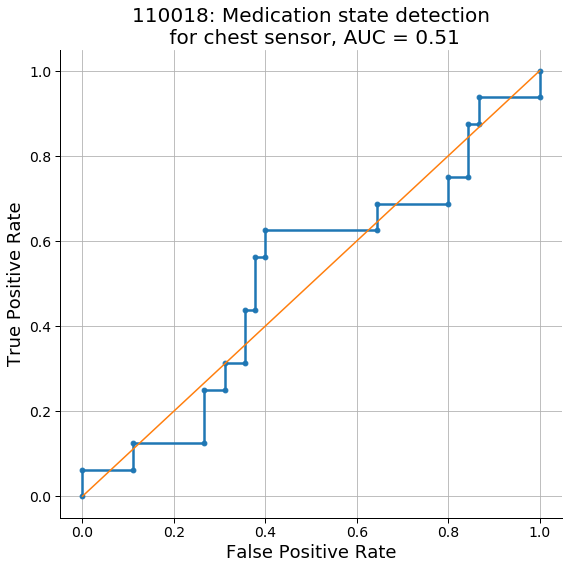

In [105]:
predictMedState(pt='110018', sensor_source='chest')


Participant 110018 has overall auc 0.733333


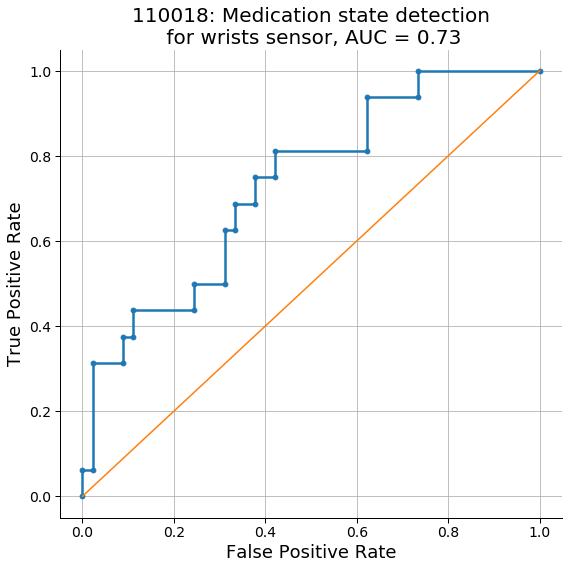

In [106]:
predictMedState(pt='110018', sensor_source='wrists')

